In [ ]:
import torch
import torchvision
import cv2
import torchvision.transforms as transforms
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import heapq
from keras.models import load_model

import sys
    "sys.path.insert(0,'/data/src/')\n",
from data import LungDataset, blend, Pad, Crop, Resize
from models import UNet, PretrainedUNet
from metrics import jaccard, dice, auc, precision, recall, accuracy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
sys.path.insert(0,'/data/src/')

from data import LungDataset, blend, Pad, Crop, Resize

In [4]:
img = cv2.imread("/Users/esmasert/Desktop/LUNGPROJECTALL/PaperRelated/MehransData/TestSelected1kImages/results/Class0/class0_COVID-2214_Majorit_voted.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [5]:
stringg=""
for row in gray:
    for itemIn in range(0,len(row)-1):
        stringg+=str(row[itemIn])+" "
    stringg+=str(row[itemIn+1])
    stringg+="\n"       

(512, 512, 1)


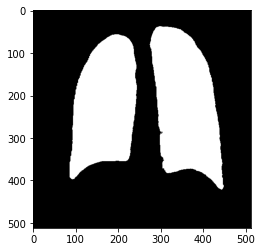

In [6]:
img = stringg.split()
img = ['0' if x == '' else x for x in img]

image_list = np.array(img,dtype = 'float')
X_train = image_list.reshape(512,512,1)
print(X_train.shape)

plt.imshow(X_train.reshape(512,512),cmap='gray')
plt.show()

In [ ]:
resultFolder="/data/TestSelected1kImages/results/Check_Class0_HEATMAP/"
modelFolder="/data/models/"

test_files= glob.glob(resultFolder + "/*.png")
print(len(test_files))


if not os.path.exists(resultFolder):
    os.makedirs(resultFolder)


print("FOLD CREATRED")
print("Reading the image...")

img = cv2.imread("/data/TestSelected1kImages/results/Class0/class0_COVID-2214_Majorit_voted.png")
if img is None:
    print("Error: Could not read the image. Please check the file path.")
else:
    print(f"Image shape: {img.shape}")
    print("Image read successfully!")

#img = cv2.resize(img,(512,512))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
heatmaps = []

heatmapFileName = resultFolder + "heatmapForImage_class0_COVID-2214_Majorit_voted.png" 
segmentedFileName = resultFolder + "segmentedImage_class0_COVID-2214_Majorit_voted.png" 
classMaskFileName = resultFolder + "classMask_class0_COVID-2214_Majorit_voted.png"

(1, 512, 512, 1)


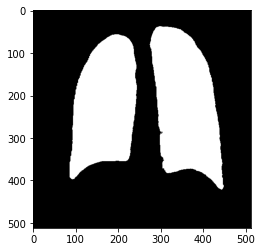

In [8]:
#Testing to see if our DataGenerator is working
X_batch = next(DataGenerator(X_train).__iter__())
print(X_batch.shape)

#Plot a single image overlayed with its heatmaps
plt.imshow(X_batch.reshape(512,512), cmap='gray', alpha=1)

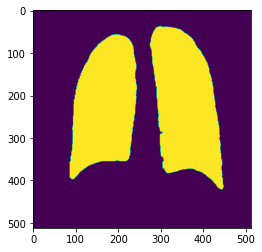

In [9]:
plt.imshow(X_batch.reshape(512,512))

# Predict with The HeatMap Model

In [ ]:
heatMapModel = load_model("/data/HeatMapCrossValTrainingResults/chosen_models2/weights-improvement-21_CV5.hdf5")
#print(model.summary())

In [13]:
index=0
HeatMapPredictions = heatMapModel.predict(X_batch)

1/1 [==============================] - 6s 6s/step


(512, 512)


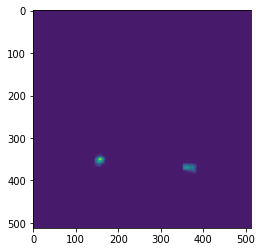

In [14]:
HeatMapresultImage= HeatMapPredictions[1][index].sum(axis=2)
plt.imshow(HeatMapresultImage)
print(HeatMapresultImage.shape)

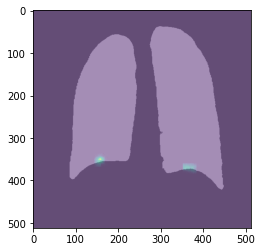

In [15]:
#Plot a single image overlayed with its heatmaps
plt.imshow(X_batch.reshape(512,512), cmap='gray', alpha=0.5)
plt.imshow(HeatMapresultImage, alpha=0.5)

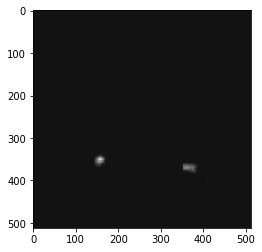

In [16]:
plt.imshow(HeatMapresultImage, cmap='gray')
plt.show()

In [17]:
plt.imsave(resultFolder + "ResultHeatMap_gray.jpg", HeatMapresultImage, cmap='gray')

In [18]:
def sliding_window(image, stepSize, windowSize):
    windowAreaList=[]
    windowArea=0
    
    for x in range(0, image.shape[0]-windowSize, stepSize):
        for y in range(0, image.shape[1]-windowSize, stepSize):
            windowArea =0
            for num1 in range(0,windowSize):
                for num2 in range(0,windowSize):
                    #print(image[x+num1][y+num2])
                    windowArea+=image[x+num1][y+num2]
                    
            temp=[]
            temp.append(windowArea)
            temp.append(x)
            temp.append(y)
            
            windowAreaList.append(temp)
            
    return windowAreaList
            
            
#windows = sliding_window(HeatMapresultImage, 5, 10)


In [19]:
def divideImageGetPoints(img):
    
    # Read the image
    height, width = img.shape

    # Cut the image in half
    width_cutoff = width // 2
    s1 = img[:, :width_cutoff]
    s2 = img[:, width_cutoff:]
    
    wwindowSize=10
    stepSize=5

    windowsLeft = sliding_window(s1, stepSize, wwindowSize)
    windowsRight = sliding_window(s2, stepSize, wwindowSize)
                
    print("Len Windows Left:", len(windowsLeft))
    print("Len Windows Right:", len(windowsLeft))
    print("Len WindowSize:", wwindowSize)

    justWindowAreas=[]
    for i in windowsLeft:
        justWindowAreas.append(i[0])
    largest2nums = heapq.nlargest(1, enumerate(justWindowAreas), key=lambda x: x[1])
    print(windowsLeft[largest2nums[0][0]])
    point1=windowsLeft[largest2nums[0][0]][2],windowsLeft[largest2nums[0][0]][1]
    cpoint1=int(point1[0]+(wwindowSize/2)),int(point1[1]+(wwindowSize/2))
    
    justWindowAreas=[]
    for i in windowsRight:
        justWindowAreas.append(i[0])
    largest2nums = heapq.nlargest(1, enumerate(justWindowAreas), key=lambda x: x[1])
    print(windowsRight[largest2nums[0][0]])
    point2=windowsRight[largest2nums[0][0]][2],windowsRight[largest2nums[0][0]][1]
    cpoint2=int(point2[0]+(wwindowSize/2))+256,int(point2[1]+(wwindowSize/2))
    
    print("Most intensive area centers: ",cpoint1,cpoint2)

    return cpoint1,cpoint2


In [20]:
cpoint1, cpoint2 = divideImageGetPoints(HeatMapresultImage)

Len Windows Left: 5050
Len Windows Right: 5050
Len WindowSize: 10
[34.40700230747461, 345, 155]
[24.543546065688133, 365, 100]
Most intensive area centers:  (160, 350) (361, 370)


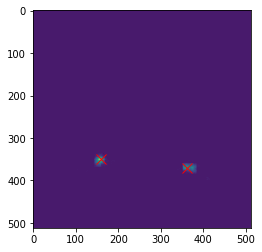

In [21]:
plt.imshow(HeatMapresultImage)
#plt.scatter(point1, point2, marker="x", color="red")
plt.plot(cpoint1[0], cpoint1[1], "x", markersize=10, color="red")  # og:shorthand for green circle
plt.plot(cpoint2[0], cpoint2[1], "x", markersize=10, color="red")  # og:shorthand for green circle
plt.show()

**Comparing the most intensive points with Predicted Segmentation:**

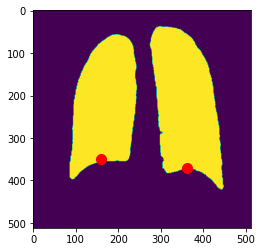

In [22]:
fig1 = plt.gcf()
plt.imshow(X_batch.reshape(512,512))
#plt.scatter(point1, point2, marker="x", color="red")
plt.plot(cpoint1[0], cpoint1[1], "o", markersize=10, color="red")  # og:shorthand for green circle
plt.plot(cpoint2[0], cpoint2[1], "o", markersize=10, color="red")  # og:shorthand for green circle
plt.show()
fig1.savefig(resultFolder + "PointsOnSegmentationMask.jpg", dpi=100)